# Path Integrating Recurrent Neural Network

## Set up

In [12]:
# autoreload
%load_ext autoreload
%autoreload 2
# jupyter black formatter
%load_ext jupyter_black

import subprocess
import os
import sys

gitroot_path = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], universal_newlines=True
)

os.chdir(os.path.join(gitroot_path[:-1], "pirnns"))
print("Working directory: ", os.getcwd())

sys_dir = os.path.dirname(os.getcwd())
sys.path.append(sys_dir)
print("Directory added to path: ", sys_dir)
sys.path.append(os.getcwd())
print("Directory added to path: ", os.getcwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
Working directory:  C:\Users\nuref\Desktop\Grid Cells\path_integration\pirnns\pirnns
Directory added to path:  C:\Users\nuref\Desktop\Grid Cells\path_integration\pirnns
Directory added to path:  C:\Users\nuref\Desktop\Grid Cells\path_integration\pirnns\pirnns


## Define the task datamodule

The datamodule is responsible for loading the training and validation datasets.

This defines the inputs and outputs of the neural computation.

In [13]:
import lightning as L
from torch.utils.data import DataLoader
import torch
import math
from torch.utils.data import TensorDataset


class PathIntegrationDataModule(L.LightningDataModule):
    def __init__(
        self,
        batch_size: int,
        train_val_split: float,
        start_time: float,
        end_time: float,
        num_time_steps: int,
        arena_L: float = 5,  # length of 2D square arena
        mu_speed: float = 1,
        sigma_speed: float = 0.5,  # speed noise (std)
        tau_vel: float = 1,  # Velocity autocorrelation timescale (controls smoothness of motion)
        # A small tau_vel means velocity changes rapidly — more jittery, random walk–like behavior
        # A large tau_vel means velocity persists longer — motion is smoother and more inertial
        # tau_vel = 1 is a good default value for balanced noise and smoothness -- mouse exploring
    ) -> None:
        super().__init__()
        self.batch_size = batch_size
        self.train_val_split = train_val_split
        self.start_time = start_time
        self.end_time = end_time
        self.num_time_steps = num_time_steps
        self.dt = (end_time - start_time) / num_time_steps

        self.arena_L = arena_L
        self.mu_speed = mu_speed
        self.sigma_speed = sigma_speed
        self.tau_vel = tau_vel

    def _simulate_trajectories(
        self,
        device: str = "cpu",
    ) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Simulates a batch of trajectories following the Ornstein-Uhlenbeck process.
        (Brownian motion with a drift term).

        Parameters
        ----------
        device : str
            The device to use for the simulation.
        Returns
        -------
        x         : (batch, T, 2), [heading, speed] at each time step
        positions : (batch, T, 2), ground-truth (x,y) positions (optional target)
        """
        # --- initial position & velocity ----------------------------------------
        pos = torch.rand(self.batch_size, 2, device=device) * self.arena_L
        # sample initial heading uniformly in (0, 2pi), speed around mu_speed
        hd0 = torch.rand(self.batch_size, device=device) * 2 * torch.pi
        spd0 = torch.clamp(
            torch.randn(self.batch_size, device=device) * self.sigma_speed
            + self.mu_speed,
            min=0.0,
        )
        # creating initial velocity vector
        vel = torch.stack((torch.cos(hd0), torch.sin(hd0)), dim=-1) * spd0.unsqueeze(-1)

        pos_all, vel_all = [pos], [vel]
        # the term sqrt(2 * dt / tau) is used to scale the Gaussian noise to match the variance required by the OU process
        sqrt_2dt_over_tau = math.sqrt(2 * self.dt / self.tau_vel)
        for _ in range(self.num_time_steps - 1):
            # OU velocity update (momentum)
            noise = torch.randn_like(vel)
            vel = (
                vel
                + (self.dt / self.tau_vel) * (-vel)
                + self.sigma_speed * sqrt_2dt_over_tau * noise
            )

            # position update
            pos = pos + vel * self.dt

            # --- reflective boundaries: If position goes out of bounds, it's mirrored back and velocity flipped ----------
            out_left = pos[:, 0] < 0
            out_right = pos[:, 0] > self.arena_L
            out_bottom = pos[:, 1] < 0
            out_top = pos[:, 1] > self.arena_L

            # reflect positions and flip corresponding velocity component
            if out_left.any():
                pos[out_left, 0] *= -1
                vel[out_left, 0] *= -1
            if out_right.any():
                pos[out_right, 0] = 2 * self.arena_L - pos[out_right, 0]
                vel[out_right, 0] *= -1
            if out_bottom.any():
                pos[out_bottom, 1] *= -1
                vel[out_bottom, 1] *= -1
            if out_top.any():
                pos[out_top, 1] = 2 * self.arena_L - pos[out_top, 1]
                vel[out_top, 1] *= -1

            pos_all.append(pos)
            vel_all.append(vel)

        vel_all = torch.stack(vel_all, 1)  # (batch, T, 2)
        pos_all = torch.stack(pos_all, 1)  # (batch, T, 2)
        # Compute speed from velocity vector
        speeds = torch.linalg.norm(vel_all, dim=-1)
        # Compute heading angle from velocity vector
        headings = torch.atan2(vel_all[..., 1], vel_all[..., 0]) % (2 * torch.pi)
        # Stack headings and speeds to create input tensor
        input = torch.stack((headings, speeds), dim=-1)  # (batch, T, 2)
        return input, pos_all

    def setup(self, stage=None) -> None:
        input, target = self._simulate_trajectories(device="cpu")
        self.train_dataset = TensorDataset(input, target)
        self.val_dataset = TensorDataset(input, target)

    def train_dataloader(self) -> DataLoader:
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self) -> DataLoader:
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False)

Instantiate the datamodule

In [14]:
datamodule = PathIntegrationDataModule(
    batch_size=128,  # Simulate 128 independent 2D agent trajectories
    train_val_split=0.8,
    start_time=0,
    end_time=100,
    num_time_steps=1000,  # The simulation is discretized into 1000 time steps
    arena_L=5,  # The agents move in a 2D square arena of size 5x5
    mu_speed=0.2,
    sigma_speed=0.5,
    tau_vel=1,
)
datamodule.setup()

Visualize example trajectory

C:\Users\nuref\AppData\Local\Temp\ipykernel_20632\3297901368.py:12: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  v_x = speeds * np.cos(head_directions)
C:\Users\nuref\AppData\Local\Temp\ipykernel_20632\3297901368.py:13: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  v_y = speeds * np.sin(head_directions)


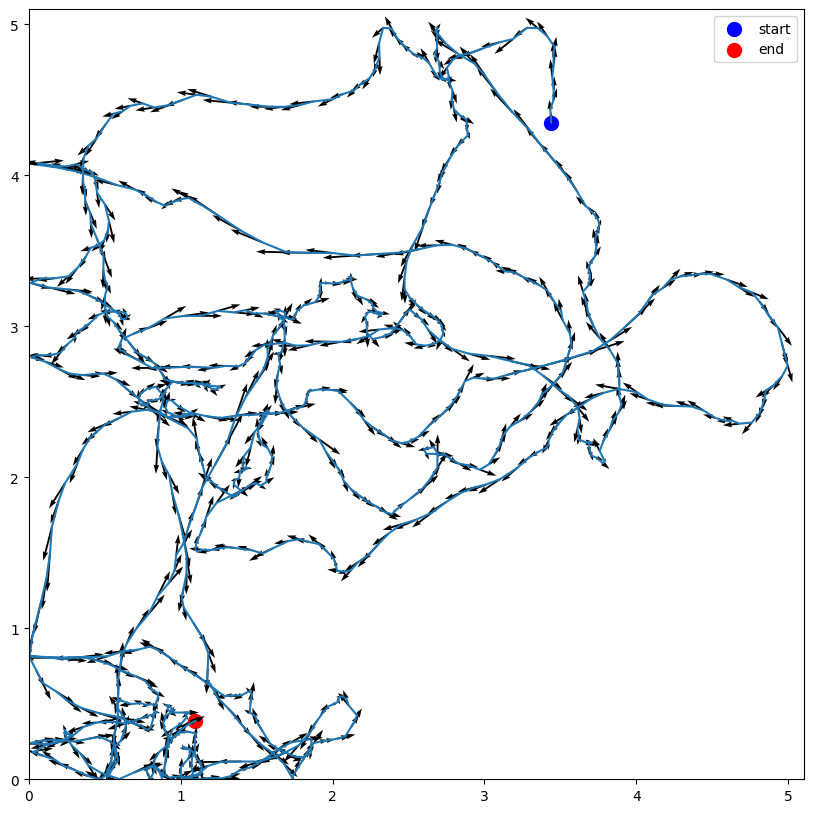

In [15]:
import numpy as np
import matplotlib.pyplot as plt

loader = datamodule.train_dataloader()
batch_inputs, batch_positions = next(iter(loader))

positions = batch_positions[0, :, :]

head_directions = batch_inputs[0, :, 0]
speeds = batch_inputs[0, :, 1]

v_x = speeds * np.cos(head_directions)
v_y = speeds * np.sin(head_directions)


plt.figure(figsize=(10, 10))
# set limits
plt.xlim(0, 5.1)
plt.ylim(0, 5.1)

# plot start and end points
plt.scatter(positions[0, 0], positions[0, 1], color="blue", label="start", s=100)
plt.scatter(positions[-1, 0], positions[-1, 1], color="red", label="end", s=100)
plt.legend()

# plot trajectories
plt.plot(positions[:, 0], positions[:, 1])

# plot velocity vectors
plt.quiver(positions[:, 0], positions[:, 1], v_x, v_y)
plt.show()

## Define the model to be trained on the task

In [16]:
import torch
import torch.nn as nn


class RNNStep(nn.Module):
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        alpha: float,
        activation: type[nn.Module] = nn.Tanh,
    ) -> None:
        """
        A single time step of the RNN.
        """
        super(RNNStep, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.alpha = alpha
        self.activation = activation()

        self.W_in = nn.Linear(input_size, hidden_size)
        self.W_rec = nn.Linear(hidden_size, hidden_size)

    # leaky RNN update
    def forward(self, input: torch.Tensor, hidden: torch.Tensor) -> torch.Tensor:
        h = (1 - self.alpha) * hidden + self.alpha * self.activation(
            self.W_in(input) + self.W_rec(hidden)
        )
        return h


class PathIntRNN(nn.Module):
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        output_size: int,
        alpha: float = 0.1,
        activation: type[nn.Module] = nn.Tanh,
    ) -> None:
        """
        Initialize the Path Integrating RNN.
        :param input_size: The size of the velocity input (= dimension of space).
        :param hidden_size: The size of the hidden state (number of neurons/"grid cells").
        :param output_size: The size of the output vector (dimension of space).
        :param alpha: RNN update rate.
        :param activation: The activation function.
        """
        super(PathIntRNN, self).__init__()
        self.input_size: int = input_size
        self.hidden_size: int = hidden_size
        self.output_size: int = output_size

        self.rnn_step = RNNStep(input_size, hidden_size, alpha, activation)
        self.W_out = nn.Linear(hidden_size, output_size)

        # Layer to initialize hidden state
        self.W_h_init = nn.Linear(2, hidden_size)

        self.initialize_weights()

    def forward(
        self, inputs: torch.Tensor, pos_0: torch.Tensor
    ) -> tuple[torch.Tensor, torch.Tensor]:
        # inputs has shape (batch_size, time_steps, input_size)
        # pos_0 has shape (batch_size, 2)
        hidden_states = []
        outputs = []
        # Initialize hidden state from initial position
        hidden = torch.tanh(self.W_h_init(pos_0))
        for t in range(inputs.shape[1]):
            input_t = inputs[:, t, :]
            hidden = self.rnn_step(input_t, hidden)
            hidden_states.append(hidden)
            outputs.append(self.W_out(hidden))
        return torch.stack(hidden_states, dim=1), torch.stack(outputs, dim=1)

    def initialize_weights(self) -> None:
        """Initialize weights for stable RNN training"""
        # 1. Input weights (W_in) - Xavier initialization
        nn.init.xavier_uniform_(self.rnn_step.W_in.weight)
        nn.init.zeros_(self.rnn_step.W_in.bias)

        # 2. Recurrent weights (W_rec) - Orthogonal initialization
        # Helps mitigate vanishing/exploding gradients over time steps
        nn.init.orthogonal_(self.rnn_step.W_rec.weight)
        nn.init.zeros_(self.rnn_step.W_rec.bias)

        # 3. Output weights (W_out) - Xavier initialization
        nn.init.xavier_uniform_(self.W_out.weight)
        nn.init.zeros_(self.W_out.bias)

        # 4. Initial hidden state encoder (W_h_init) - Xavier initialization
        nn.init.xavier_uniform_(self.W_h_init.weight)
        nn.init.zeros_(self.W_h_init.bias)

In [17]:
model_10 = PathIntRNN(input_size=2, hidden_size=10, output_size=2, alpha=0.5)
print(model_10)

PathIntRNN(
  (rnn_step): RNNStep(
    (activation): Tanh()
    (W_in): Linear(in_features=2, out_features=10, bias=True)
    (W_rec): Linear(in_features=10, out_features=10, bias=True)
  )
  (W_out): Linear(in_features=10, out_features=2, bias=True)
  (W_h_init): Linear(in_features=2, out_features=10, bias=True)
)


In [23]:
model_64 = PathIntRNN(input_size=2, hidden_size=64, output_size=2, alpha=0.5)
print(model_64)

PathIntRNN(
  (rnn_step): RNNStep(
    (activation): Tanh()
    (W_in): Linear(in_features=2, out_features=64, bias=True)
    (W_rec): Linear(in_features=64, out_features=64, bias=True)
  )
  (W_out): Linear(in_features=64, out_features=2, bias=True)
  (W_h_init): Linear(in_features=2, out_features=64, bias=True)
)


## Instantiate the lightning module and Trainer

The model lightning module is responsible for implementing the training and validation steps.

This involves defining the loss function, the optimizer, and the learning rate scheduler.

The trainer is responsible for training the model.

In [18]:
import lightning as L
import torch.nn as nn


class PathIntRNNLightning(L.LightningModule):
    def __init__(
        self,
        model: nn.Module,
        lr: float = 0.01,
        num_epochs: int = 100,
        model_name: str = "model",
    ) -> None:
        super().__init__()
        self.model = model
        self.lr = lr
        self.num_epochs = num_epochs
        self.model_name = model_name

        self.train_losses: list[torch.Tensor] = []
        self.val_losses: list[torch.Tensor] = []

    def training_step(self, batch) -> torch.Tensor:
        inputs, targets = batch
        # inputs has shape (batch_size, time_steps, input_size)
        # targets has shape (batch_size, time_steps, output_size)
        hidden_states, outputs = self.model(inputs=inputs, pos_0=targets[:, 0, :])

        loss = nn.functional.mse_loss(outputs, targets)

        self.log("train_loss", loss)

        self.train_losses.append(loss)
        return loss

    def validation_step(self, batch) -> torch.Tensor:
        inputs, targets = batch
        hidden_states, outputs = self.model(inputs=inputs, pos_0=targets[:, 0, :])

        loss = nn.functional.mse_loss(outputs, targets)

        self.log("val_loss", loss)

        self.val_losses.append(loss)
        return loss

    def configure_optimizers(self) -> torch.optim.Optimizer:
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

    def on_validation_epoch_end(self):
        epoch = self.current_epoch
        if (epoch + 1) % 10 == 0:
            path = f"{self.model_name}_epoch_{epoch+1}.pt"
            torch.save(self.model.state_dict(), path)
            print(f"Saved model checkpoint: {path}")

In [19]:
rnn_lightning_10 = PathIntRNNLightning(
    model=model_10, lr=0.01, num_epochs=100, model_name="model10"
)

print(rnn_lightning_10)

PathIntRNNLightning(
  (model): PathIntRNN(
    (rnn_step): RNNStep(
      (activation): Tanh()
      (W_in): Linear(in_features=2, out_features=10, bias=True)
      (W_rec): Linear(in_features=10, out_features=10, bias=True)
    )
    (W_out): Linear(in_features=10, out_features=2, bias=True)
    (W_h_init): Linear(in_features=2, out_features=10, bias=True)
  )
)


In [ ]:
rnn_lightning_64 = PathIntRNNLightning(
    model=model_64, lr=0.01, num_epochs=100, model_name="model64"
)
print(rnn_lightning_64)

PathIntRNNLightning(
  (model): PathIntRNN(
    (rnn_step): RNNStep(
      (activation): Tanh()
      (W_in): Linear(in_features=2, out_features=64, bias=True)
      (W_rec): Linear(in_features=64, out_features=64, bias=True)
    )
    (W_out): Linear(in_features=64, out_features=2, bias=True)
    (W_h_init): Linear(in_features=2, out_features=64, bias=True)
  )
)


## Train the model

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"

rnn_lightning_10.model.to(device)


trainer = L.Trainer(
    max_epochs=100, num_sanity_val_steps=0, logger=False, enable_checkpointing=False
)

train_loader = datamodule.train_dataloader()
val_loader = datamodule.val_dataloader()

trainer.fit(rnn_lightning_10, train_loader, val_loader)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | PathIntRNN | 192    | train
---------------------------------------------
192       Trainable params
0         Non-trainable params
192       Total params
0.001     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | PathIntRNN | 192    | train
---------------------------------------------
192       Trainable params
0         No

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Saved model checkpoint: model10_epoch_10.pt


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Saved model checkpoint: model10_epoch_20.pt


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Saved model checkpoint: model10_epoch_30.pt


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Saved model checkpoint: model10_epoch_40.pt


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Saved model checkpoint: model10_epoch_50.pt


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Saved model checkpoint: model10_epoch_60.pt


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Saved model checkpoint: model10_epoch_70.pt


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Saved model checkpoint: model10_epoch_80.pt


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Saved model checkpoint: model10_epoch_90.pt


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Saved model checkpoint: model10_epoch_100.pt


In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"

rnn_lightning_64.model.to(device)


trainer = L.Trainer(
    max_epochs=100, num_sanity_val_steps=0, logger=False, enable_checkpointing=False
)

train_loader = datamodule.train_dataloader()
val_loader = datamodule.val_dataloader()

trainer.fit(rnn_lightning_64, train_loader, val_loader)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | PathIntRNN | 4.7 K  | train
---------------------------------------------
4.7 K     Trainable params
0         Non-trainable params
4.7 K     Total params
0.019     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | PathIntRNN | 4.7 K  | train
---------------------------------------------
4.7 K     Trainable params
0         No

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Saved model checkpoint: model64_epoch_10.pt


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Saved model checkpoint: model64_epoch_20.pt


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Saved model checkpoint: model64_epoch_30.pt


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Saved model checkpoint: model64_epoch_40.pt


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Saved model checkpoint: model64_epoch_50.pt


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Saved model checkpoint: model64_epoch_60.pt


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Saved model checkpoint: model64_epoch_70.pt


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Saved model checkpoint: model64_epoch_80.pt


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Saved model checkpoint: model64_epoch_90.pt


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Saved model checkpoint: model64_epoch_100.pt


Visualize the training loss, validation loss, and accuracy.

### Results when hidden_size=10

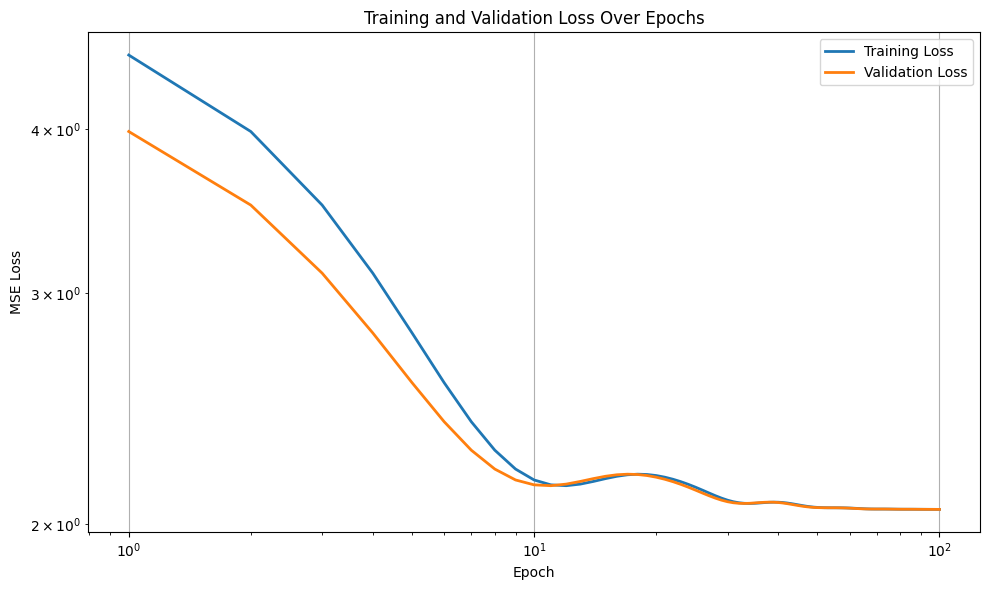

In [21]:
import matplotlib.pyplot as plt
import torch


def plot_training_curves(rnn_lightning: PathIntRNNLightning) -> None:
    train_losses = [
        loss.item() if isinstance(loss, torch.Tensor) else loss
        for loss in rnn_lightning.train_losses
    ]
    val_losses = [
        loss.item() if isinstance(loss, torch.Tensor) else loss
        for loss in rnn_lightning.val_losses
    ]

    epochs = list(range(1, len(train_losses) + 1))

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label="Training Loss", linewidth=2)
    plt.plot(epochs, val_losses, label="Validation Loss", linewidth=2)

    plt.xscale("log")
    plt.yscale("log")

    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title("Training and Validation Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_training_curves(rnn_lightning_10)

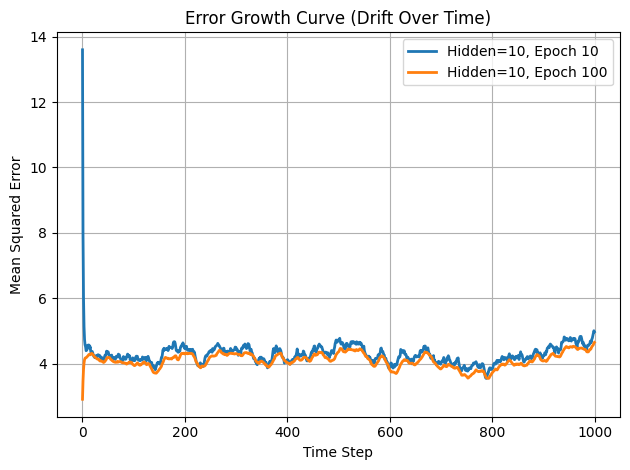

In [ ]:
import torch
import matplotlib.pyplot as plt


def plot_error_growth_curve(model, dataloader, device="cpu", label=None):
    model.eval()
    model.to(device)

    all_errors = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            _, outputs = model(inputs=inputs, pos_0=targets[:, 0, :])

            # Compute Euclidean error at each time step: shape (batch, time)
            errors = torch.norm(outputs - targets, dim=-1)  # shape: (batch, time)
            all_errors.append(errors.pow(2))  # store squared error

    # Stack all errors across batches: shape (total_batches * batch_size, time)
    all_errors = torch.cat(all_errors, dim=0)  # shape: (N, T)
    mse_per_timestep = all_errors.mean(dim=0)  # shape: (T,)

    # Plot
    plt.plot(mse_per_timestep.cpu().numpy(), label=label, linewidth=2)
    plt.xlabel("Time Step")
    plt.ylabel("Mean Squared Error")
    plt.title("Error Growth Curve (Drift Over Time)")
    plt.grid(True)
    if label:
        plt.legend()
    plt.tight_layout()


model10_10 = PathIntRNN(input_size=2, hidden_size=10, output_size=2, alpha=0.5)
model10_10.load_state_dict(torch.load("model10_epoch_10.pt"))
model10_10.eval()

model10_100 = PathIntRNN(input_size=2, hidden_size=10, output_size=2, alpha=0.5)
model10_100.load_state_dict(torch.load("model10_epoch_100.pt"))
model10_100.eval()

plot_error_growth_curve(
    model10_10, datamodule.val_dataloader(), label="Hidden=10, Epoch 10"
)
plot_error_growth_curve(
    model10_100, datamodule.val_dataloader(), label="Hidden=10, Epoch 100"
)
plt.show()

### Results when hidden_size=64

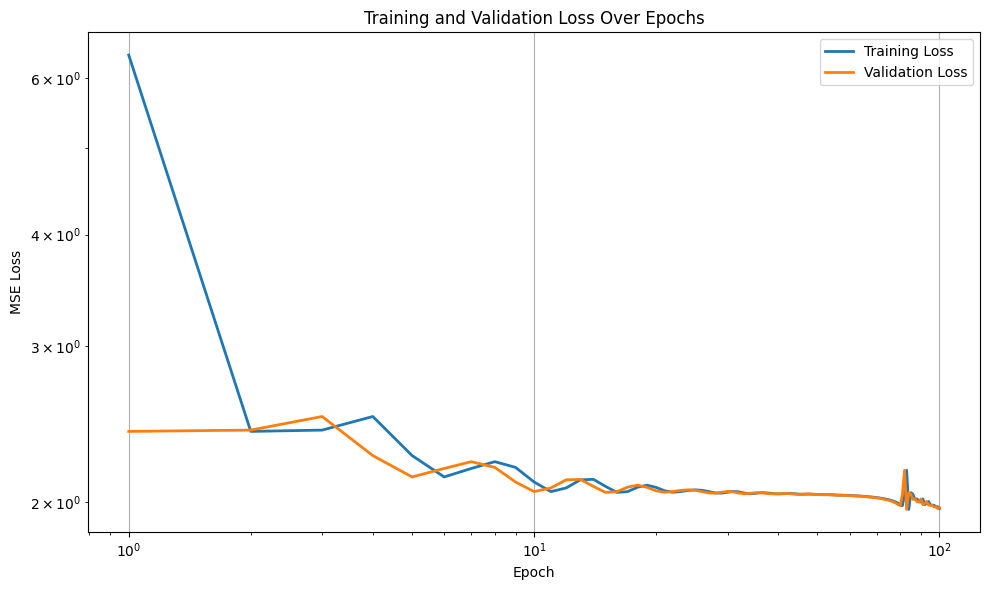

In [26]:
plot_training_curves(rnn_lightning_64)

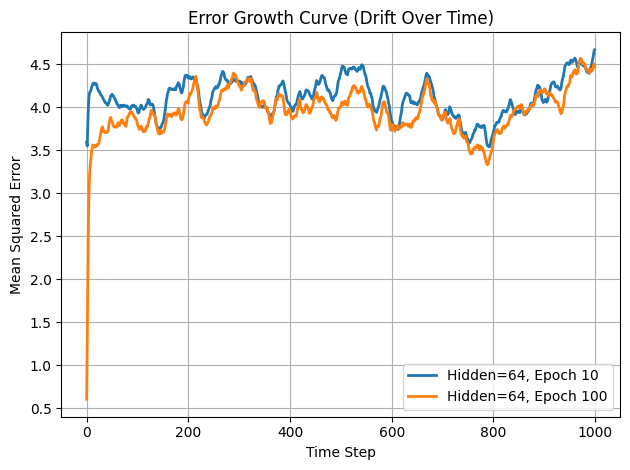

In [28]:
model64_10 = PathIntRNN(input_size=2, hidden_size=64, output_size=2, alpha=0.5)
model64_10.load_state_dict(torch.load("model64_epoch_10.pt"))
model64_10.eval()

model64_100 = PathIntRNN(input_size=2, hidden_size=64, output_size=2, alpha=0.5)
model64_100.load_state_dict(torch.load("model64_epoch_100.pt"))
model64_100.eval()

plot_error_growth_curve(
    model64_10, datamodule.val_dataloader(), label="Hidden=64, Epoch 10"
)
plot_error_growth_curve(
    model64_100, datamodule.val_dataloader(), label="Hidden=64, Epoch 100"
)
plt.show()

## Simple visualizations of a few hidden neurons

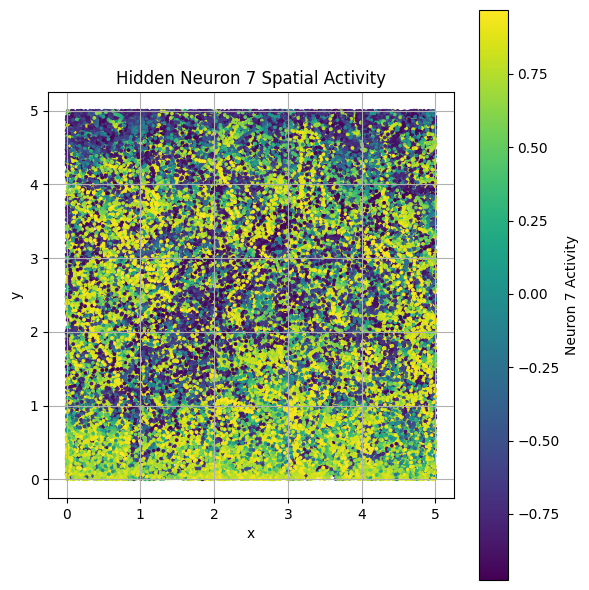

In [ ]:
#-----take one of the fully trained networks --> model64_epoch_100
model_64 = PathIntRNN(input_size=2, hidden_size=64, output_size=2, alpha=0.5)
model_64.load_state_dict(torch.load("model64_epoch_100.pt"))
model_64.eval()

#-----Pass it a large batch of trajectories
inputs, targets = next(iter(datamodule.val_dataloader()))
hidden_states, outputs = model_64(inputs=inputs, pos_0=targets[:, 0, :])

#-----Choose one hidden neuron to visualize
neuron_idx = 7
neuron_activity = hidden_states[:, :, neuron_idx]  # shape: (batch, time)

#-----Combine all trajectories into one 2D plot
import matplotlib.pyplot as plt

#Flatten (batch, time) → (N,)
flat_x = targets[:, :, 0].reshape(-1).detach().cpu().numpy()
flat_y = targets[:, :, 1].reshape(-1).detach().cpu().numpy()
flat_act = neuron_activity.reshape(-1).detach().cpu().numpy()

plt.figure(figsize=(6, 6))
sc = plt.scatter(flat_x, flat_y, c=flat_act, cmap="viridis", s=3)
plt.colorbar(sc, label=f"Neuron {neuron_idx} Activity")
plt.xlabel("x")
plt.ylabel("y")
plt.title(f"Hidden Neuron {neuron_idx} Spatial Activity")
plt.gca().set_aspect("equal")
plt.grid(True)
plt.tight_layout()
plt.show()

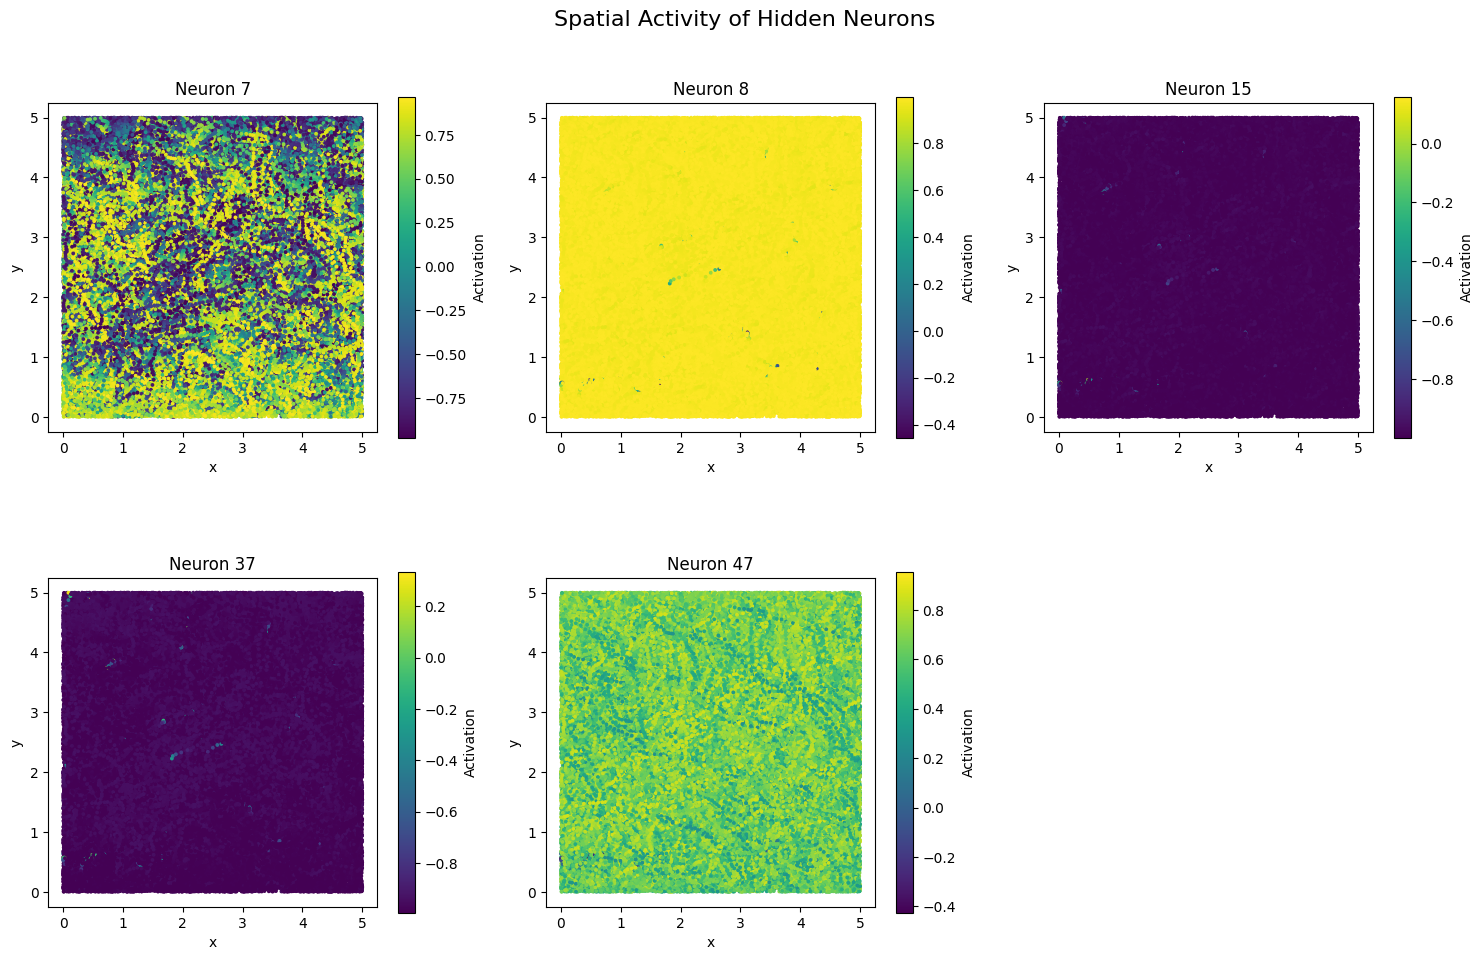

In [35]:
import matplotlib.pyplot as plt
import torch


def visualize_multiple_hidden_neurons(
    model, dataloader, neuron_indices=[0, 1, 2, 3, 4], device="cpu"
):
    model.eval()
    model.to(device)

    # Get a large batch of validation trajectories
    inputs, targets = next(iter(dataloader))
    inputs = inputs.to(device)
    targets = targets.to(device)

    # Forward pass to get hidden states
    with torch.no_grad():
        hidden_states, _ = model(
            inputs=inputs, pos_0=targets[:, 0, :]
        )  # (batch, time, hidden_size)

    # Flatten all (batch, time) into (N,)
    flat_pos = targets.reshape(-1, 2).detach().cpu().numpy()  # shape: (N, 2)
    flat_hidden = (
        hidden_states.reshape(-1, hidden_states.shape[-1]).detach().cpu().numpy()
    )  # shape: (N, hidden_size)

    # Create subplots
    n = len(neuron_indices)
    n_cols = min(3, n)
    n_rows = (n + n_cols - 1) // n_cols  # ceil division

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
    axs = axs.flatten()  # make 1D array for easy indexing

    for i, neuron_idx in enumerate(neuron_indices):
        ax = axs[i]
        activity = flat_hidden[:, neuron_idx]
        sc = ax.scatter(flat_pos[:, 0], flat_pos[:, 1], c=activity, cmap="viridis", s=3)
        ax.set_title(f"Neuron {neuron_idx}")
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_aspect("equal")
        fig.colorbar(sc, ax=ax, shrink=0.75, label="Activation")

    # Remove unused axes if fewer than grid size
    for j in range(len(neuron_indices), len(axs)):
        fig.delaxes(axs[j])

    plt.suptitle("Spatial Activity of Hidden Neurons", fontsize=16)
    plt.tight_layout()
    plt.show()


visualize_multiple_hidden_neurons(
    model_64, datamodule.val_dataloader(), neuron_indices=[7, 8, 15, 37, 47]
)

## Analyze the weights & activations